# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import re
import csv
import glob
import warnings
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
576,dokujo-tsushin,0,音楽とスポーツをファッショナブルに楽しむためのヘッドホンが誕,今年2月、2007年の初開催から4回目を迎えるアジア最大級の市民マラソン東京マラソンが行われ...
1586,it-life-hack,1,芸能ゴシップネタはこちら！ITライフハックでは読めない話題は三面貴族で読もう,先日公開されたlivedoorニュースのリーダーアプリ三面貴族bylivedoorニュース芸...
887,it-life-hack,1,新型MBP登場で盛り上がったWWDC！iPhone5も7インチiPadminiもなし,iPhone5やiPadminiは姿を見せるか？アップルのWWDCを日本語で解説を見た人には...
1051,it-life-hack,1,これが次世代スマートフォン！ドコモXperiaacroHDSO-03D開封レポー,ドコモのXperiaacroHDSO-03Dが3月15日、つまり今日ついに発売された。Xpe...
1389,it-life-hack,1,これは気づかなかった！古いノートPCがWebテレビに格安で変身する裏,最近の液晶テレビの進化は目覚ましく、地デジ化が完了したと思ったら、今度はインターネットに接続...
107,dokujo-tsushin,0,胸の谷間見せはどこまでOK？セクシーとビッチの別れ道を探る,オノヨーコ78の胸の谷間を目にするたびに、なんだかザワザワした気持ちになるのは私だけでしょう...
256,dokujo-tsushin,0,独女卒業の最後の難関？彼の両親に挨拶にいく必勝,独女がいよいよ独女ではなくなる時それは?結婚?。結婚相手となる運命の人が長い間現れなかった人...
862,dokujo-tsushin,0,応援する？ムカつく？あなたの近くの社内恋,クリスマスが近づくにつれて、活気づいてくる恋愛事情。尚子さん既婚38歳メーカー勤務の会社でも...
1466,it-life-hack,1,PSPソックリのAndroid端末が登場！レッドスター、携帯ゲーム機JXD5000を販売,レッドスターは2012年2月24日、携帯ゲーム機JXD5000の販売を3月23日より開始する...
445,dokujo-tsushin,0,流行は回帰するブログが再び面白い理,最近またブログが面白くなってきてさーこうつぶやくのは、独女の礼子さん35歳会社員。礼子さんが...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
wcount = 128

'''
# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][:wcount]

#'''

'''
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][-wcount:]
'''

# ushiro kara wcount moji toru ichiban ketsu wa toranai

for i in enumerate(sentences):
    if len(i[1])>wcount:
        am = wcount+10
        a = sentences[i[0]][-am:]
        sentences[i[0]] = a[:wcount]
#'''

In [8]:
sentences[0]

'女性かと思っていた。もしかしたら、こんな時期だからこそ決断できたのかもしれないと思った。ウディアレン監督の映画ボギー！俺も男だのなかでこんな一節がある。結婚は互いを孤独にするものさ。でも、独り者の孤独よりいいと。胸に刺さる台詞だ。確かにそうかもしれない。オ'

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [9]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  女性かと思っていた。もしかしたら、こんな時期だからこそ決断できたのかもしれないと思った。ウディアレン監督の映画ボギー！俺も男だのなかでこんな一節がある。結婚は互いを孤独にするものさ。でも、独り者の孤独よりいいと。胸に刺さる台詞だ。確かにそうかもしれない。オ
Tokenized:  ['▁女性', 'か', 'と思っていた', '。', 'も', 'しかし', 'たら', '、', 'こんな', '時期', 'だから', 'こそ', '決断', 'できた', 'の', 'かもしれない', 'と思った', '。', 'ウ', 'ディア', 'レン', '監督の', '映画', 'ボギー', '!', '俺', 'も', '男', 'だ', 'のなかで', 'こんな', '一', '節', 'がある', '。', '結婚', 'は', '互', 'い', 'を', '孤独', 'に', 'するもの', 'さ', '。', 'でも', '、', '独', 'り', '者の', '孤独', 'より', 'いい', 'と', '。', '胸', 'に', '刺', 'さ', 'る', '台詞', 'だ', '。', '確か', 'に', 'そう', 'かもしれない', '。', 'オ']
Token IDs:  [15394, 95, 19479, 8, 30, 9680, 9176, 7, 15420, 1913, 6129, 3643, 12294, 2747, 10, 6254, 12700, 8, 409, 3356, 854, 3278, 244, 25712, 543, 8145, 30, 629, 314, 10184, 15420, 92, 979, 91, 8, 1743, 11, 14135, 128, 18, 20280, 17, 4266, 338, 8, 153, 7, 2596, 101, 1458, 20280, 94, 2505, 20, 8, 4032, 17, 3704, 338, 56, 10963, 314, 8, 15352, 17, 1043, 6254, 8, 233]


In [10]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  90
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [11]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  女性かと思っていた。もしかしたら、こんな時期だからこそ決断できたのかもしれないと思った。ウディアレン監督の映画ボギー！俺も男だのなかでこんな一節がある。結婚は互いを孤独にするものさ。でも、独り者の孤独よりいいと。胸に刺さる台詞だ。確かにそうかもしれない。オ
Token IDs: tensor([15394,    95, 19479,     8,    30,  9680,  9176,     7, 15420,  1913,
         6129,  3643, 12294,  2747,    10,  6254, 12700,     8,   409,  3356,
          854,  3278,   244, 25712,   543,  8145,    30,   629,   314, 10184,
        15420,    92,   979,    91,     8,  1743,    11, 14135,   128,    18,
        20280,    17,  4266,   338,     8,   153,     7,  2596,   101,  1458,
        20280,    94,  2505,    20,     8,  4032,    17,  3704,   338,    56,
        10963,   314,     8, 15352,    17,  1043,  6254,     8,   233,     2,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3

In [12]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

len(validation_dataloader)

訓練データ数：1566
検証データ数:　174 


6

In [13]:
len(next(iter(validation_dataloader))[2])

32

In [14]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

2022-12-21 22:26:00.311413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 22:26:00.387484: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-21 22:26:00.402110: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-21 22:26:00.636293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [16]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [17]:
import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
'''
        if preds == b_labels:
            correct += 1
            #test_accuracy += torch.sum(preds == b_labels).item() / len(b_labels)

#test_accuracy = correct/len(b_labels)
print(correct)
'''
print(statistics.mean(test_accuracy))


0.96875


In [18]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[-1.0817, -0.0904, -0.8481, -2.0677],
        [-0.3407, -1.5455,  1.2380, -1.0304],
        [-0.8273, -0.3669, -1.1275, -0.0505],
        [-0.7967,  0.6619,  0.2777, -1.8393]])
tensor(6)


In [19]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 5.2271, -5.4974],
        [-5.0253,  5.3065],
        [-5.0460,  5.3661],
        [-4.9598,  5.2446],
        [ 5.1298, -5.3012],
        [-5.0308,  5.3731],
        [-5.0678,  5.2832],
        [-5.1307,  5.3089],
        [-4.9902,  5.3695],
        [ 5.2673, -5.5236],
        [ 5.2526, -5.4017],
        [ 5.3088, -5.5232],
        [-4.9857,  5.2457],
        [-4.3665,  4.6298]], device='cuda:0'), hidden_states=None, attentions=None)


In [20]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,5.227103,-5.497393,0,0
1,-5.025292,5.306532,1,1
2,-5.045981,5.366110,1,1
3,-4.959792,5.244645,1,1
4,5.129779,-5.301152,0,0


In [21]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

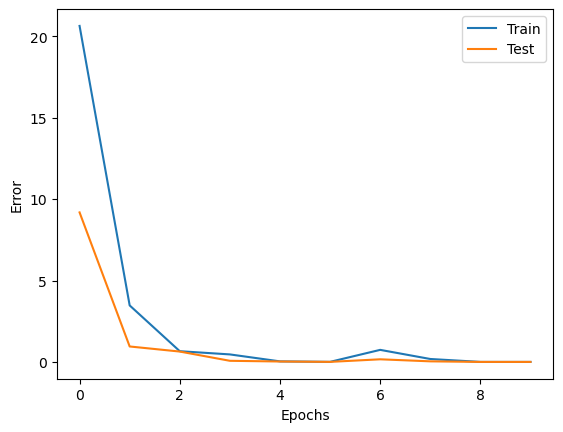

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと

In [23]:
np.argmax(preds[0].cpu().numpy(), axis=1)

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1])

In [24]:
import pickle
with open('headmodel.pickle', mode='wb') as fp:
    pickle.dump(model, fp)